<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.DigitRecognizer/blob/main/0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - Create a baseline with Batch Normalization, without looking on the Internet
    - Create a baseline with Dropout, without looking on the Internet
    - Implement classic architectures (AlexNet, VGG), without looking
    - Implement model checkpoint callbacks (save every epoch)
    - Write NN with functional API, not looking on the Internet
    - Enwrap your FFNN for grid search CV and find the best architecture
    - Stretch pants approach
    - Correct initialization strategies for different activation functions
    - Use functools.partial in building sequential model
    - Transfer learning

# Imports

In [1]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

## Pep 8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

# Helper functions

In [3]:
def reshape(arr):
    return arr.reshape(arr.shape[0], 28, 28)

In [4]:
def plot_history(history_):
    _, ax = plt.subplots(1, 2, figsize=(8, 3))

    ax[0].plot(
        history.history['loss'],
        label='loss'
    )
    ax[0].plot(
        history.history['val_loss'],
        label='val_loss'
    )

    ax[0].legend()

    ax[1].plot(
        history.history['accuracy'],
        label='acc'
    )
    ax[1].plot(
        history.history['val_accuracy'],
        label='val_acc'
    )
    ax[1].legend()

## Custom packages

In [5]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [6]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Setup paths

In [8]:
drive.mount('/content/gdrive', force_remount=True)  # force_remount=True
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 'ResNet_transfer_learning'
MODELS_TRIAL = 'baseline'
COMPETITION_PATH = gdrive_path + 'ML/Competitions/3.DigitRecognizer/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/3.DigitRecognizer/Data/preproc_trial_ResNet_transfer_learning already exists
/content/gdrive/MyDrive/ML/Competitions/3.DigitRecognizer/Models/trial_baseline already exists


# Download the data

In [9]:
df_train = pd.read_csv(manager.train_path)
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_test = pd.read_csv(manager.test_path)
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Quick data exporation

## Nan values

In [ ]:
assert not df_train.isna().any().any()
assert not df_test.isna().any().any()

In [ ]:
import numpy as np
print(np.max(df_train.values), np.min(df_train.values))
print(np.max(df_test.values), np.min(df_test.values))

255 0
255 0


## Class balance

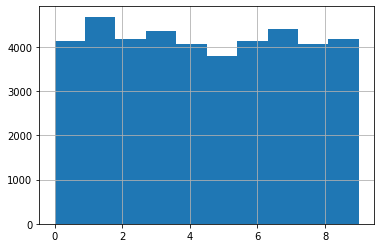

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
df_train['label'].hist(ax=ax)

# Create train, validation and test sets

In [11]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.99
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['label']
)
df_trainval.shape, df_test.shape

((41580, 785), (28000, 784))

In [12]:
TRAIN_SIZE = 0.8

df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['label']
)
df_train.shape, df_validation.shape

((33264, 785), (8316, 785))

# Data exploration (from now on, on train set)

In [ ]:
vals = df_train.values[0, 1:]
type(vals)

numpy.ndarray

(-0.5, 27.5, 27.5, -0.5)

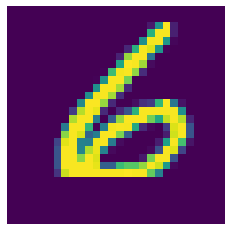

In [ ]:
plt.imshow(vals.reshape(28, 28))
plt.axis('off')

# Data preparation

- Standardize the data
- Transform Y into vector form

In [13]:
df_train.shape, \
df_validation.shape, \
df_test.shape, \
df_test_sample.shape

((33264, 785), (8316, 785), (28000, 784), (420, 785))

In [14]:
def get_X_Y(df_):
    assert 'label' in df_.columns
    Y = df_['label']
    df_dropped = df_.drop(['label'], axis='columns')
    X = df_dropped.values
    assert len(np.unique(Y)) == 10
    return X, Y
    

In [15]:
X_train, Y_train = get_X_Y(df_train)
X_validation, Y_validation = get_X_Y(df_validation)

In [16]:
X_test_sample, Y_test_sample = get_X_Y(df_test_sample)
X_test = df_test.values

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
X_train = X_train / 255.0  # scaler.fit_transform(X_train)
X_validation = X_validation / 255.0  # scaler.transform(X_validation)
X_test_sample = X_test_sample / 255.0  # scaler.transform(X_test_sample)
X_test = X_test / 255.0  # scaler.transform(X_test)

In [20]:
def report(arrs_):
    for arr_ in arrs_:
        print(np.max(arr_), np.min(arr_))

report([X_train, X_validation, X_test_sample, X_test])

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


In [21]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y_train = enc.fit_transform(np.array(Y_train).reshape(-1, 1)).toarray()
Y_validation = enc.transform(np.array(Y_validation).reshape(-1, 1)).toarray()
Y_test_sample = enc.transform(np.array(Y_test_sample).reshape(-1, 1)).toarray()

In [22]:
def get_subsample(percentage):
    
    X_train_subsample, _, Y_train_subsample, _ = train_test_split(
        X_train,
        Y_train,
        train_size=percentage,  # 0.8,
        random_state=RANDOM_STATE,
        stratify=Y_train
    )

    X_validation_subsample, _, Y_validation_subsample, _ = \
        train_test_split(
            X_validation,
            Y_validation,
            train_size=percentage,  # 0.1,
            random_state=RANDOM_STATE,
            stratify=Y_validation
    )
    
    return {
        "train": (X_train_subsample, Y_train_subsample),
        "validation": (X_validation_subsample, Y_validation_subsample)
    }

In [23]:
res = get_subsample(0.3)

X_train_subsample, Y_train_subsample = res['train']
X_validation_subsample, Y_validation_subsample = res['validation']

X_train_subsample.shape, Y_train_subsample.shape, \
X_validation_subsample.shape, Y_validation_subsample.shape, \
X_train.shape

((9979, 784), (9979, 10), (2494, 784), (2494, 10), (33264, 784))

In [24]:
report([X_train_subsample, X_validation_subsample])

1.0 0.0
1.0 0.0


# Save data

In [ ]:
# manager.save_to_csv(
#     df_train,
#     manager.data_trial_path,
#     'train_processed.csv'
# )

# manager.save_to_csv(
#     df_val,
#     manager.data_trial_path,
#     'val_processed.csv'
# )

In [ ]:
# manager.save_to_csv(
#     df_test_sample,
#     manager.data_trial_path,
#     'test_sample_processed.csv'
# )

In [ ]:
# manager.save_to_csv(
#     df_test,
#     manager.data_trial_path,
#     'test_processed.csv'
# )

# Model preparation

## Sequential baseline

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from functools import partial
import tensorflow

dense_layer = partial(
    Dense,
    activation='relu',
    kernel_initializer=tensorflow.keras.initializers.HeNormal()
)

ffnn_baseline = Sequential(
    [
        Input(shape=(784,)),
        dense_layer(units=784),
        dense_layer(units=300),
        dense_layer(units=300),
        dense_layer(units=300),
        Dropout(0.4),
        Dense(units=10, activation='softmax')
    ]
)

In [ ]:
ffnn_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
X_train.shape, Y_train.shape

((26880, 784), (26880, 10))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
history = ffnn_baseline.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=32,
    epochs=50,
    callbacks=[EarlyStopping(patience=2)]
)

Epoch 1/50
840/840 [==============================] - 14s 15ms/step - loss: 0.3727 - accuracy: 0.8953 - val_loss: 0.2126 - val_accuracy: 0.9397
Epoch 2/50
840/840 [==============================] - 14s 16ms/step - loss: 0.1776 - accuracy: 0.9511 - val_loss: 0.2225 - val_accuracy: 0.9408
Epoch 3/50
840/840 [==============================] - 14s 16ms/step - loss: 0.1383 - accuracy: 0.9619 - val_loss: 0.1803 - val_accuracy: 0.9563
Epoch 4/50
840/840 [==============================] - 13s 15ms/step - loss: 0.1144 - accuracy: 0.9692 - val_loss: 0.1699 - val_accuracy: 0.9567
Epoch 5/50
840/840 [==============================] - 13s 15ms/step - loss: 0.0958 - accuracy: 0.9725 - val_loss: 0.2189 - val_accuracy: 0.9497
Epoch 6/50
840/840 [==============================] - 15s 18ms/step - loss: 0.0948 - accuracy: 0.9763 - val_loss: 0.2176 - val_accuracy: 0.9513


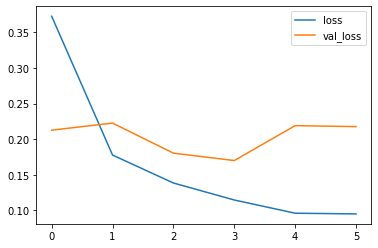

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()

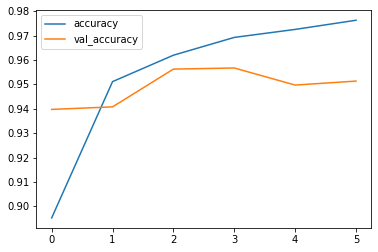

In [ ]:
_, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend()

## Enwrap FFNN into grid search CV

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def build_model(
    n_hidden_layers_=3,
    dropout_rate_=0.3,
    width_=100,
    activation_='relu',
    learning_rate_=0.0001
):
    model = Sequential()
    model.add(Input(shape=(784,)))
    model.add(Dense(28 * 28, activation=activation_))

    for _ in range(n_hidden_layers_ - 2):
        model.add(Dense(units=width_, activation=activation_))
    
    model.add(Dropout(dropout_rate_))

    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate_),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
keras_reg = KerasRegressor(build_model)

<ipython-input-106-e1ebe08fc635>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_model)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal


In [ ]:
estimator = RandomizedSearchCV(
    keras_reg,
    {
        'n_hidden_layers_': list(range(2, 5)),
        'dropout_rate_': [0.2, 0.3, 0.4, 0.5],
        # 'learning_rate_': [0.001, 0.0001, 0.0015],
        'learning_rate_': [3e-4, 3e-2],
        'width_': [200, 300, 350, 400,]
    },
    cv=4,
    n_iter=3
)

In [ ]:
res = estimator.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=20,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    batch_size=32,
    callbacks=[EarlyStopping(patience=2, mode='min', monitor='val_accuracy')]
)

Epoch 1/20
315/315 [==============================] - 5s 15ms/step - loss: 0.6974 - accuracy: 0.8039 - val_loss: 0.3650 - val_accuracy: 0.9000
Epoch 2/20
315/315 [==============================] - 4s 13ms/step - loss: 0.2532 - accuracy: 0.9258 - val_loss: 0.2947 - val_accuracy: 0.9164
Epoch 3/20
105/105 [==============================] - 1s 5ms/step - loss: 0.2300 - accuracy: 0.9354
Epoch 1/20
315/315 [==============================] - 5s 15ms/step - loss: 0.7162 - accuracy: 0.7971 - val_loss: 0.3560 - val_accuracy: 0.9048
Epoch 2/20
315/315 [==============================] - 4s 14ms/step - loss: 0.2575 - accuracy: 0.9236 - val_loss: 0.2756 - val_accuracy: 0.9223
Epoch 3/20
105/105 [==============================] - 1s 5ms/step - loss: 0.2166 - accuracy: 0.9369
Epoch 1/20
315/315 [==============================] - 5s 14ms/step - loss: 0.6881 - accuracy: 0.8041 - val_loss: 0.3820 - val_accuracy: 0.9015
Epoch 2/20
315/315 [==============================] - 4s 14ms/step - loss: 0.2594 - a

In [ ]:
res.best_params_, \
    res.best_score_,

({'width_': 350,
  'n_hidden_layers_': 3,
  'learning_rate_': 0.0001,
  'dropout_rate_': 0.2},
 -0.22469522058963776)

In [ ]:
res.best_estimator_.model

## Baseline CNN

In [ ]:
from functools import partial

conv_layer = partial(
    layers.Conv2D,
    activation='relu',
    kernel_size=(3, 3)
)

baseline_cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        conv_layer(filters=32), # (5, 5) kernel used to be before
        conv_layer(filters=64),
        layers.MaxPool2D(pool_size=2),
        conv_layer(filters=128),
        
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ]
)

In [ ]:
early_stopper = EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min'
)

In [ ]:
baseline_cnn.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
)

In [ ]:
history = baseline_cnn.fit(
    X_train.reshape(X_train.shape[0], 28, 28),
    Y_train,
    validation_data=(
        X_validation.reshape(X_validation.shape[0], 28, 28), Y_validation
    ),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopper]
)

Epoch 1/20
 62/840 [=>............................] - ETA: 3:09 - loss: 0.8439 - accuracy: 0.7248

KeyboardInterrupt: ignored

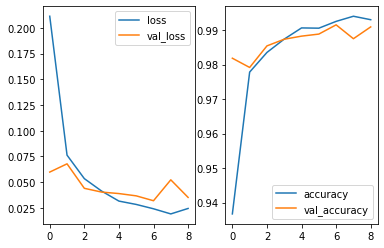

In [ ]:
_, ax = plt.subplots(1, 2)
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()

## Enwrap baseline CNN into randomized search

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.optimizers import Adam

from functools import partial


def build_cnn(
    activation_func_='relu',
    dropout_rate_=0.4,
    learning_rate_=0.001
):

    if activation_func_ == 'relu':
        initializer = 'he_normal'
    if activation_func_ == 'selu':
        initializer = 'lecun_normal'

    conv_layer = partial(
        Conv2D,
        activation=activation_func_,
        kernel_initializer=initializer,
        kernel_size=(3, 3)
    )

    dense_layer = partial(
        Dense,
        activation=activation_func_,
        kernel_initializer=initializer
    )

    # model = Sequential(
    #     [
    #         Input(shape=(28, 28, 1)),
    #         Flatten(),
    #         Dense(10, activation='softmax')
    #     ]
        
    # )

    model = Sequential(
        [
            Input(shape=(28, 28, 1)),
            conv_layer(filters=32),
            conv_layer(filters=64),
            MaxPool2D(pool_size=(2, 2)),

            conv_layer(filters=128),
            Flatten(),
            dense_layer(units=100),
            Dropout(dropout_rate_),
            Dense(units=10, activation='softmax')
        ]
    )

    model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        optimizer=Adam(learning_rate=learning_rate_)
    )
    return model

In [ ]:
cnn_builder = tensorflow.keras.wrappers.scikit_learn.KerasRegressor(build_cnn)

<ipython-input-234-90810bec11a3>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_builder = tensorflow.keras.wrappers.scikit_learn.KerasRegressor(build_cnn)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

cnn_estimator = GridSearchCV(
    cnn_builder,
    {
        'activation_func_': ['selu'],
        'dropout_rate_': [0.4, 0.6],
        'learning_rate_': [0.001, 0.0001]
    },
    cv=2,
    # n_iter=10,
    verbose=3
)

In [ ]:
res = get_subsample(0.6)
X_subsample, Y_subsample = res['train']
X_val_subsample, Y_val_subsample = res['validation']

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping



cnn_res = cnn_estimator.fit(
    reshape(X_subsample),  # reshape(X_train),  # reshape(X_subsample),
    Y_subsample,  # Y_train,  #  Y_subsample,
    # validation_data=(reshape(X_val_subsample), Y_val_subsample),
    validation_data=(reshape(X_validation), Y_validation),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=2, monitor='val_loss', mode='min')
    ]
)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/20
252/252 [==============================] - 43s 166ms/step - loss: 0.5511 - accuracy: 0.8528 - val_loss: 0.1475 - val_accuracy: 0.9555
Epoch 2/20
252/252 [==============================] - 41s 163ms/step - loss: 0.1538 - accuracy: 0.9554 - val_loss: 0.0931 - val_accuracy: 0.9717
Epoch 3/20
252/252 [==============================] - 41s 164ms/step - loss: 0.0948 - accuracy: 0.9701 - val_loss: 0.0765 - val_accuracy: 0.9754
Epoch 4/20
252/252 [==============================] - 43s 172ms/step - loss: 0.0689 - accuracy: 0.9781 - val_loss: 0.0823 - val_accuracy: 0.9781
Epoch 5/20
252/252 [==============================] - 9s 34ms/step - loss: 0.0790 - accuracy: 0.9785
[CV 1/2] END activation_func_=relu, dropout_rate_=0.4, learning_rate_=0.001;, score=-0.079 total time= 4.5min
Epoch 1/20
252/252 [==============================] - 42s 164ms/step - loss: 0.5596 - accuracy: 0.8535 - val_loss: 0.1278 - val_accuracy: 0.9609
Epoc

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def reshape(arr):
    return arr.reshape(arr.shape[0], 28, 28)

cnn_res = cnn_estimator.fit(
    reshape(X_subsample),  # reshape(X_train),  # reshape(X_subsample),
    Y_subsample,  # Y_train,  #  Y_subsample,
    # validation_data=(reshape(X_val_subsample), Y_val_subsample),
    validation_data=(reshape(X_validation), Y_validation),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=2, monitor='val_loss', mode='min')
    ]
)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Epoch 1/20
252/252 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.8473

KeyboardInterrupt: ignored

## AlexNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from functools import partial

conv_layer = partial(
    Conv2D,
    activation='relu'
)

alex_net = Sequential(
    [
        Input(shape=(227, 227, 3)),  # Put your own input size here!
        
        conv_layer(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid'),
        MaxPool2D(pool_size=(3, 3), strides=2, padding='valid'),
        
        conv_layer(filters=256, kernel_size=(5, 5), strides=1, padding='same'),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
     
        conv_layer(filters=384, kernel_size=(3, 3), strides=1, padding='same'),
        conv_layer(filters=384, kernel_size=(3, 3), strides=1, padding='same'),
        conv_layer(filters=256, kernel_size=(3, 3), strides=1, padding='same'),
        
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        
        Dense(10, activation='softmax')  # Originally 1000 units
        
    ]
)

In [ ]:
X_train.shape

(26880, 784)

## Baseline CNN with data augmentation

In [25]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [26]:
data_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

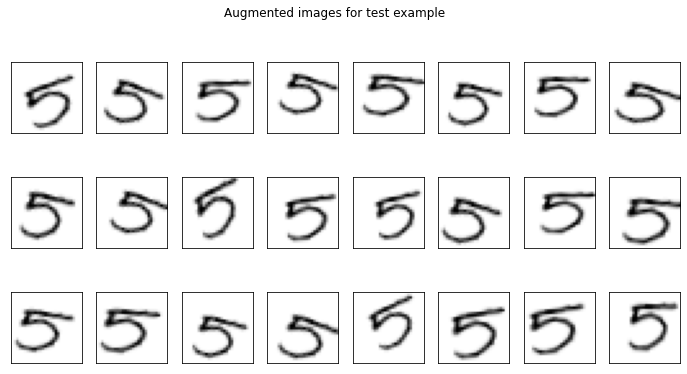

In [27]:
idx = 10
fig, axes = plt.subplots(3,8, figsize=(12,6))
x = X_train[idx].reshape(-1, 28, 28, 1)
y = Y_train[idx].reshape(-1, 10)

fig.suptitle('Augmented images for test example')
for i in range(3):
    for j in range(8):
        augmented_example_X, augmented_example_y = data_generator.flow(
            x, y, batch_size=1).next()
        axes[i,j].imshow(augmented_example_X.squeeze(), cmap='Greys')
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [28]:
train_generator = data_generator.flow(
    X_train.reshape(X_train.shape[0], 28, 28, 1),
    Y_train,
    batch_size=32
)

In [29]:
steps_per_epoch = train_generator.n // train_generator.batch_size
steps_per_epoch

1039

In [31]:
from functools import partial

conv_layer = partial(
    layers.Conv2D,
    activation='relu',
    kernel_size=(3, 3)
)

baseline_cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        conv_layer(filters=32), # (5, 5) kernel used to be before
        conv_layer(filters=64),
        layers.MaxPool2D(pool_size=2),
        conv_layer(filters=128),
        conv_layer(filters=128),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(300, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ]
)

In [32]:
baseline_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = baseline_cnn.fit(
    train_generator,
    validation_data=(reshape(X_validation), Y_validation),
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]
)

Epoch 1/20
1039/1039 [==============================] - 189s 181ms/step - loss: 0.4213 - accuracy: 0.8650 - val_loss: 0.0527 - val_accuracy: 0.9840
Epoch 2/20
1039/1039 [==============================] - 179s 172ms/step - loss: 0.1360 - accuracy: 0.9593 - val_loss: 0.0430 - val_accuracy: 0.9865
Epoch 3/20
1039/1039 [==============================] - 181s 175ms/step - loss: 0.1043 - accuracy: 0.9693 - val_loss: 0.0409 - val_accuracy: 0.9877
Epoch 4/20
1039/1039 [==============================] - 179s 173ms/step - loss: 0.0831 - accuracy: 0.9759 - val_loss: 0.0396 - val_accuracy: 0.9909
Epoch 5/20
1039/1039 [==============================] - 180s 174ms/step - loss: 0.0772 - accuracy: 0.9779 - val_loss: 0.0481 - val_accuracy: 0.9870
Epoch 6/20
1039/1039 [==============================] - 181s 174ms/step - loss: 0.0755 - accuracy: 0.9776 - val_loss: 0.0331 - val_accuracy: 0.9907
Epoch 7/20
1039/1039 [==============================] - 180s 173ms/step - loss: 0.0685 - accuracy: 0.9813 - val_

## Pretrained ResNet 50

In [41]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Input,
    Flatten,
    Dropout
)

resnet = Sequential()
resnet.add(Input(shape=(28, 28, 3)))
resnet.add(
    ResNet50(include_top=False, pooling='avg', weights='imagenet')
)
resnet.add(Flatten())
resnet.add(Dropout(0.4))
resnet.add(Dense(10, activation='softmax'))

In [42]:
resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
def reshape_for_resnet(X_):
    X_reshaped = reshape(X_)
    X_reshaped = np.stack([X_reshaped, X_reshaped, X_reshaped], axis=-1)
    return X_reshaped

def prepare_resnet_data(X_, Y_):
    X_reshaped = reshape(X_)
    X_reshaped = np.stack([X_reshaped, X_reshaped, X_reshaped], axis=-1)
    X_reshaped = resnet_preprocess(X_reshaped)
    return X_reshaped, Y_

In [30]:
X_train_resnet, Y_train_resnet = prepare_resnet_data(
    X_train, Y_train)

report([X_train])
report([X_train_resnet, X_train_subsample, X_validation_subsample])

1.0 0.0
-102.939 -123.68
1.0 0.0
1.0 0.0


In [31]:
X_validation_resnet, Y_validation_resnet = prepare_resnet_data(
    X_validation, Y_validation)

report([X_validation_resnet])

-102.939 -123.68


In [32]:
X_train_subsample_resnet, Y_train_subsample_resnet = \
    prepare_resnet_data(
        X_train_subsample,
        Y_train_subsample
    )

In [33]:
X_validation_subsample_resnet, Y_validation_subsample_resnet = \
    prepare_resnet_data(
        X_validation_subsample,
        Y_validation_subsample
    )

In [34]:
report([X_train_subsample_resnet, X_validation_subsample_resnet])

-102.939 -123.68
-102.939 -123.68


In [35]:
report([X_train_subsample, X_validation_subsample])

1.0 0.0
1.0 0.0


In [37]:
X_train_subsample.shape

(9979, 784)

In [44]:
resnet_history = resnet.fit(
    reshape_for_resnet(X_train_subsample), # X_train_subsample_resnet,
    Y_train_subsample, # Y_train_subsample_resnet,
    # validation_data=(
        # X_validation_subsample_resnet, Y_validation_subsample_resnet),
    validation_data=(reshape_for_resnet(X_validation_subsample), Y_validation_subsample),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3
    )]
)

Epoch 1/20
312/312 [==============================] - 21s 49ms/step - loss: 0.7049 - accuracy: 0.8606 - val_loss: 2.3644 - val_accuracy: 0.2851
Epoch 2/20
312/312 [==============================] - 13s 43ms/step - loss: 0.2729 - accuracy: 0.9423 - val_loss: 1.3573 - val_accuracy: 0.4980
Epoch 3/20
312/312 [==============================] - 14s 45ms/step - loss: 0.5796 - accuracy: 0.8922 - val_loss: 50.4702 - val_accuracy: 0.3561
Epoch 4/20
227/312 [====================>.........] - ETA: 3s - loss: 0.5567 - accuracy: 0.8939

KeyboardInterrupt: ignored

# Hyperparameters tuning

In [ ]:
!pip install keras_tuner

In [ ]:
import keras_tuner as kt
from functools import partial
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout
)
from tensorflow.keras import Model

ModuleNotFoundError: ignored

In [ ]:
def build_model(hyperparam):
    dropout_rate = hyperparam.Choice(
        'dropout_rate',
        [0.1, 0.2, 0.3, 0.4])
    final_dropout_rate = hyperparam.Choice(
        'final_dropout_rate',
        [0.3, 0.4, 0.5]
    )
    kernel_size = hyperparam.Choice(
        'kernel_size',
        [3, 5])
    n_conv_blocks = hyperparam.Choice(
        'n_conv_blocks',
        [2, 3, 4]
    )

    filter_combination = hyperparam.Choice(
        'filter_combination',
        [0, 1, 2, 3]
    )

    n_fully_connected_layers = hyperparam.Choice(
        'n_fully_connected_layers',
        [1, 2, 3])
    fc_units_choice = hyperparam.Choice(
        'fc_units_choice',
        [0, 1]
    )

    fc_comb_1 = [[100], [200]],
    fc_comb_2 = [[200, 100], [300, 200]]
    fc_comb_3 = [[500, 300, 100], [300, 200, 100], [150, 100, 50]]

    filter_combinations_two_layers = [
        [16, 32], [32, 64], [64, 128], [128, 256]
    ]
    filter_combinations_three_layers = [
        [16, 32, 48], [16, 32, 64], [32, 64, 128], [64, 128, 256]
    ]
    filter_combinations_four_layers = [
        [16, 16, 32, 32], [32, 32, 64, 64], [64, 64, 128, 128],
        [128, 128, 256, 256]
    ]

    if n_conv_blocks == 2:
        filter_combinations = filter_combinations_two_layers
    elif n_conv_blocks == 3:
        filter_combinations = filter_combinations_three_layers
    elif n_conv_blocks == 4:
        filter_combinations = filter_combinations_four_layers
    

    # Build the network
    conv_layer = partial(
        Conv2D,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        activation='relu'
    )

    input = Input(shape=(28, 28, 1))
    x = conv_layer(filters=filter_combinations[0])(input)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    for i in range(1, n_conv_blocks):
        x = conv_layer(filters=filter_combinations[i])(x),
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    if n_fully_connected_layers == 1:
        units_combo = fc_comb_1[fc_units_choice]
    elif n_fully_connected_layers == 2:
        units_combo = fc_comb_2[fc_units_choice]
    elif n_fully_connected_layers == 3:
        units_combo = fc_comb_3[fc_units_choice]
    
    for i in range(len(units_combo)):
        x = Dense(units=units_combo[i], activation='relu')(x)
    x = Dropout(final_dropout_rate)(x)
    output = Dense(units=10, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model




# Submission

In [34]:
final_model = baseline_cnn  # ffnn_baseline

In [35]:
# test_predictions = final_model.predict(X_test)
test_predictions = final_model.predict(X_test.reshape((X_test.shape[0], 28, 28)))

875/875 [==============================] - 34s 38ms/step


In [36]:
Y_test = np.argmax(test_predictions, axis=1)

In [37]:
image_ids = list(range(1, X_test.shape[0] + 1))
labels = Y_test

In [38]:
submission_df = pd.DataFrame(
    {
        'ImageId': image_ids,
        'Label': labels
    },
    index=None
)

submission_df = submission_df.set_index('ImageId')

In [39]:
manager.save_to_csv(
    submission_df,
    manager.data_trial_path,
    'submission.csv'
)